In [1]:
import psycopg2
import json
from datetime import datetime as dt
import pandas as pd
import re 
from textblob import TextBlob 

In [2]:
p="datasucks"

In [3]:
conn = psycopg2.connect(user = "alexis",
                                  password = f"{p}",
                                  host = "127.0.0.1",
                                  port = "3306",
                                  database = "postgres")

In [4]:
cursor = conn.cursor()

In [5]:
tweet_list = []
followers = []
cursor.execute("select * from tweets")
tweets = cursor.fetchall()
if not tweets:
    print("empty")
for row in tweets:
    for col in row:
        if type(col) is dict:
            tweet_list.append(col['text'])
            followers.append(col['user']['followers_count'])

In [6]:
remove_list = [r'@[A-Za-z0-9]+','https?://[A-Za-z0-9./]+','\n','RT :',r'_[A-Za-z0-9]+','  ']

In [7]:
def clean_tweets(remove_list,tweet_list):
    for item in remove_list:
        tweet_list = [re.sub(item,'',tweet) for tweet in tweet_list]
    return tweet_list

In [8]:
cleaned = clean_tweets(remove_list,tweet_list)
len(cleaned)

2316

In [9]:
def result(tweet,keyword_list):
    if any(word in tweet for word in keyword_list):
        return 1
    else:
        return 0

In [28]:
sentiment = []
subjectivity= []
bernie = []
buttigieg = []
biden = []
warren = []
gender = []
age = []
democrat = []
socialist = []
trump = []
delegates = []
extended = []
length = []
for tweet in cleaned:
    tweet_length = len(tweet)
    length.append(tweet_length)
    if tweet_length > 140:
        extended.append(1)
    else:
        extended.append(0)
    delegates.append(result(tweet.lower(),["delegate","delegates"]))
    trump.append(result(tweet.lower(),["trump","donald","donald trump","donaldtrump","donald j. trump","don"]))
    socialist.append(result(tweet.lower(),["socialist","socialism","far-left","left-extremist", "extreme left"]))
    democrat.append(result(tweet.lower(),["democrat","democratic","blue","bluestate", "blue state", "blue states"]))
    age.append(result(tweet.lower(),["old","aging","grandpa","geriatric","uncle","age"]))
    gender.append(result(tweet.lower(),["female","woman","girl","lady","women"]))
    warren.append(result(tweet.lower(),["warren",'elizabeth',"elizabethwarren","elizabeth warren"]))
    biden.append(result(tweet.lower(),["biden","joe","joebiden","joe biden"]))
    buttigieg.append(result(tweet.lower(),["buttigieg","pete","petebuttigieg","pete buttigieg"]))
    bernie.append(result(tweet.lower(),["bernie","berniesanders","sanders","bernie sanders", "feel the bern"]))
    sentiment.append([TextBlob(tweet).polarity])
    subjectivity.append([TextBlob(tweet).subjectivity])

In [29]:
data = pd.DataFrame({"bernie":bernie,"buttigieg":buttigieg,"biden":biden,"warren":warren,"gender":gender,
             "age":age,"democrat":democrat,"socialist":socialist,"trump":trump,"delegates":delegates,
             "extended":extended,"sentiment":sentiment, "subjectivity":subjectivity})
data['sentiment'] = data['sentiment'].map(lambda x: x[0])
data['subjectivity'] = data['subjectivity'].map(lambda x: x[0])

# data['sentiment'] = data['sentiment'].astype(float)
# data['sentiment'] = data['sentiment'].astype(float)

data.head()

,bernie,buttigieg,biden,warren,gender,age,democrat,socialist,trump,delegates,extended,sentiment,subjectivity
0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.75
1,0,0,0,0,0,0,1,0,0,0,0,0.2,0.25
2,0,0,0,0,0,0,0,0,0,0,0,0.5,0.90
3,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
4,0,0,0,0,0,0,0,0,0,0,0,0.2,0.50


In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12)

In [41]:
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [43]:
print(kmeans.cluster_centers_)

[[ 1.11111111e-01  1.73472348e-18  0.00000000e+00  1.85185185e-02
  -1.73472348e-17  1.85185185e-02  1.00000000e+00  1.85185185e-02
   1.00000000e+00  8.67361738e-19  0.00000000e+00  1.36246727e-02
   1.18384907e-01]
 [-1.72084569e-15  1.44230769e-02  4.80769231e-03 -1.40512602e-16
   1.68269231e-02 -3.74700271e-16 -8.32667268e-16  7.21153846e-03
  -1.27675648e-15 -8.23993651e-18  0.00000000e+00  9.20601751e-04
   5.20599951e-02]
 [-1.26287869e-15 -8.15320034e-17  3.27332242e-03  4.16333634e-17
   1.80032733e-02 -3.33066907e-16 -7.07767178e-16  9.81996727e-03
   1.63666121e-03  8.18330606e-03  0.00000000e+00  4.02894514e-01
   5.88607461e-01]
 [ 2.91433544e-16  4.08163265e-03  1.22448980e-02 -6.93889390e-17
   8.16326531e-03 -9.71445147e-17 -2.77555756e-17  5.71428571e-02
   1.00000000e+00 -6.93889390e-18  0.00000000e+00  3.25361118e-02
   2.04052993e-01]
 [ 1.28000000e-01 -1.56125113e-17  9.54097912e-18  1.90819582e-17
   7.20000000e-02  1.38777878e-16  4.16333634e-17  8.00000000e-03


In [45]:
print(kmeans.labels_)

[2 7 2 ... 2 1 1]


In [32]:
kmeans.predict(data)[:10]

array([ 6, 10,  6,  0,  6, 10,  0,  6,  5, 10])

In [33]:
# Check individual Result from 
print((data.iloc[59].values.reshape(1,13)).shape)
kmeans.predict(data.iloc[59].values.reshape(1,13))

(1, 13)


array([3])

In [34]:
data.iloc[75]

bernie          1.0
buttigieg       0.0
biden           0.0
warren          0.0
gender          0.0
age             0.0
democrat        1.0
socialist       0.0
trump           0.0
delegates       0.0
extended        0.0
sentiment       0.0
subjectivity    0.0
Name: 75, dtype: float64

In [35]:
for i,row in data.iterrows():
    if row["bernie"] == 1:
        if row["buttigieg"] ==1:
            print(f"Buttigieg: {i}")
        if row["biden"] == 1:
            print(f"Biden: {i}")
        if row["warren"] == 1:
            print(f"Warren: {i}")


Biden: 265
Buttigieg: 878
Warren: 977
Buttigieg: 1742
Warren: 1931


In [36]:
data.iloc[1931:1932]

,bernie,buttigieg,biden,warren,gender,age,democrat,socialist,trump,delegates,extended,sentiment,subjectivity
1931,1,0,0,1,0,0,1,0,0,0,0,0.0,0.0


In [37]:
data_results = data.copy()
data_results['cluster'] = kmeans.predict(data).tolist()

In [38]:
data_results.head()

,bernie,buttigieg,biden,warren,gender,age,democrat,socialist,trump,delegates,extended,sentiment,subjectivity,cluster
0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.75,6
1,0,0,0,0,0,0,1,0,0,0,0,0.2,0.25,10
2,0,0,0,0,0,0,0,0,0,0,0,0.5,0.90,6
3,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0
4,0,0,0,0,0,0,0,0,0,0,0,0.2,0.50,6


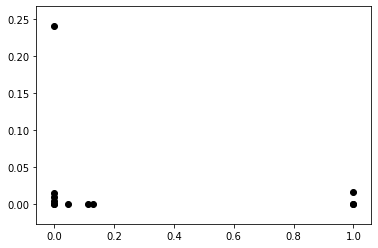

In [55]:
# plt.scatter(data[:,2],data[:,2], c=kmeans.labels_, cmap='rainbow')
# plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
